In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy as sc 
import numpy as np
import cvxpy as cvx

import sys
import os
import importlib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import covariance_functions.general_functions as gf
import covariance_functions.em_functions as em
import covariance_functions.ewma_functions as ewma
import covariance_functions.regularization_functions as reg

print(f"import start")
importlib.reload(gf)
importlib.reload(em)
importlib.reload(ewma)
importlib.reload(reg)
print(f"import end")

from covariance_functions.em_functions import *
from covariance_functions.ewma_functions import *
from covariance_functions.ewma_functions import _ewma_cov
from covariance_functions.ewma_functions import iterated_ewma
from covariance_functions.general_functions import *
from covariance_functions.regularization_functions import *


import start
import end


# Import Data

In [2]:
returns_no_rf = pd.read_csv('data/ff5_no_rf.csv')
returns_rf = pd.read_csv('data/ff5.csv')

In [3]:
returns_no_rf

,Unnamed: 0,Mkt-RF,SMB,HML,RMW,CMA
0,1963-07-01,-0.0067,0.0002,-0.0035,0.0003,0.0013
1,1963-07-02,0.0079,-0.0028,0.0028,-0.0008,-0.0021
2,1963-07-03,0.0063,-0.0018,-0.0010,0.0013,-0.0025
3,1963-07-05,0.0040,0.0009,-0.0028,0.0007,-0.0030
4,1963-07-08,-0.0063,0.0007,-0.0020,-0.0027,0.0006
...,...,...,...,...,...,...
14974,2022-12-23,0.0051,-0.0034,0.0115,0.0086,0.0046
14975,2022-12-27,-0.0051,-0.0042,0.0142,0.0113,0.0121
14976,2022-12-28,-0.0123,-0.0030,-0.0029,-0.0096,-0.0003
14977,2022-12-29,0.0187,0.0104,-0.0107,-0.0101,-0.0082


# Data Pre-Processing

In [4]:
returns_no_rf = returns_no_rf.set_index('Unnamed: 0')
returns_no_rf = returns_no_rf.rename_axis('Date', axis='index')
returns_no_rf.index = pd.to_datetime(returns_no_rf.index, format='%Y-%m-%d')
returns_no_rf

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
1963-07-01,-0.0067,0.0002,-0.0035,0.0003,0.0013
1963-07-02,0.0079,-0.0028,0.0028,-0.0008,-0.0021
1963-07-03,0.0063,-0.0018,-0.0010,0.0013,-0.0025
1963-07-05,0.0040,0.0009,-0.0028,0.0007,-0.0030
1963-07-08,-0.0063,0.0007,-0.0020,-0.0027,0.0006
...,...,...,...,...,...
2022-12-23,0.0051,-0.0034,0.0115,0.0086,0.0046
2022-12-27,-0.0051,-0.0042,0.0142,0.0113,0.0121
2022-12-28,-0.0123,-0.0030,-0.0029,-0.0096,-0.0003


# Plot Cumulative Return of Each Factors

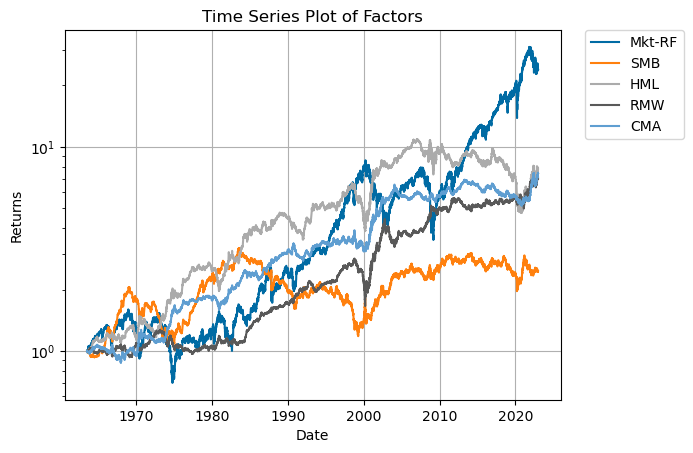

In [5]:
"""
https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
"""
columns = returns_no_rf.columns
cum_return = (returns_no_rf[columns] + 1).cumprod(axis=0)

plt.style.use('tableau-colorblind10')

plt.plot(cum_return, label=columns)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Time Series Plot of Factors')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.yscale('log')
plt.grid(True)
plt.show()

# Define Halflife Pairs
#### Specify the volatility halflife and covariance halflife for the EWMA

In [6]:
# provided
"""
rw_memory = rolling window size
    - reflect the number of trading days considered relevant.
    - 3 months = 60 days
    - 6 months = 125 days
    - 1 year = 250 days
ewma_halflife
iewma_pair = tuple (volatility halflife, covariance halflife) for a single iewma
cm_iewma_pairs = list of tuples of iewma_pairs
    - looks like the pairs are chosen to capture a variety of date ranges, from short term to 1 year
"""
rw_memory = 125   
ewma_halflife = 63
iewma_pair = (21,63)
cm_iewma_pairs = [(5, 10), (10, 21), (21, 63), (63, 125), (125, 250)]

# CM-IEWMA - Combined Multiple - Iterated Exponentially Weighted Moving Average


#### Start with IEWMA then combine it via SIGMA

In [7]:
iewma = list(iterated_ewma(returns_no_rf, vola_halflife=iewma_pair[0],cov_halflife=iewma_pair[1]))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns_no_rf, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

Running iterated_ewma
Running iterated_ewma
Running iterated_ewma
Running iterated_ewma
Running iterated_ewma
Running iterated_ewma


In [8]:
fast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, returns_no_rf, means=None).solve(window=10))

In [9]:
cm_iewma = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results} # matches

# Other Methods for Comparison

### Rolling Window Covariance Estimation

In [10]:
# general_functions: rolling_window #matches
rw = rolling_window(returns_no_rf, rw_memory) 

### EWMA - Exponentially Weighted Moving Average

In [11]:
# ewma_functions: ewma #matches
ewma = dict(_ewma_cov(returns_no_rf, halflife=ewma_halflife))

### IEWMA - Iterated Exponentially Weighted Moving Average

In [12]:
#ewma_functions: iterated_ewma  
iewma = list(iterated_ewma(returns_no_rf, vola_halflife=iewma_pair[0],cov_halflife=iewma_pair[1]))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

Running iterated_ewma


### MGARCH - Multivariate GARCH

In [13]:
mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/factor_returns/mgarch_ff5.csv", index_col=None)
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, returns_no_rf.shape[1]) / 10000

# Remove first year since it was used for training
times = returns_no_rf.index[249:] 
mgarch = {times[t]: pd.DataFrame(Sigmas[t], index=returns_no_rf.columns, columns=returns_no_rf.columns) for t in range(Sigmas.shape[0])}

NameError: name 'from_row_to_covariance' is not defined

### Prescient (Perfect Foresight Covariance Matrix)

In [ ]:
# Prescient 
prescient = {}
for t in returns_no_rf.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns_no_rf.loc[(returns_no_rf.index.year == t.year) & (returns_no_rf.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(returns_no_rf.loc[(returns_no_rf.index.year == t.year) & (returns_no_rf.index.quarter == quarter)].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=returns_no_rf.columns, columns=returns_no_rf.columns)

# Backtests
### MSE Calculation
##### Compares each method's predicted covariance matrix against actual realized covariances useing the MSE metric for each method on a quarterly basis (RW, EWMA, IEWMA, MGARCH, CM-IEWMA, Prescient)

### Log-Likelihood Calculation
##### Evaluate how well the covariance matrix fits the observed returns